In [1]:
# qraise_full_pipeline_improved.py
"""
Improved QRAISE full ML pipeline for PQC crypto-agility.
- Robust loading & cleaning
- Feature engineering
- EDA with saved + optional inline plots
- Safe resampling (SMOTE fallback)
- Train SW selector + HW classifier
- Anomaly detection (autoencoder) if TF available
- Inference helper that returns readable, generated recommendations
Outputs saved under ./artifacts/
"""

import os, re, json, warnings, pprint
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter, defaultdict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
import joblib
import random
import textwrap
from math import ceil


In [2]:

# Optional libs
try:
    import xgboost as xgb
    HAS_XGB = False
except Exception:
    HAS_XGB = False
try:
    import lightgbm as lgb
    HAS_LGB = False
except Exception:
    HAS_LGB = False
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    HAS_SMOTE = True
except Exception:
    HAS_SMOTE = False
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    HAS_TF = True
except Exception:
    HAS_TF = False


In [3]:

# USER CONFIG
ART = "artifacts"
os.makedirs(ART, exist_ok=True)
DISPLAY_PLOTS = True   # set True in Jupyter to show plots inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# -------------------------
# Helpers
# -------------------------
def try_read_csv(path):
    encs = ["utf-8","latin1","cp1252"]
    last = None
    for e in encs:
        try:
            df = pd.read_csv(path, encoding=e)
            print(f"[i] Loaded {path} with encoding={e}, shape={df.shape}")
            return df
        except Exception as ex:
            last = ex
    raise last

def clean_numeric_val(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int,float,np.number)):
        return float(v)
    s = str(v).replace('\xa0',' ').strip()
    s = s.replace('μ','u').replace('µ','u')
    for token in ["us","ms","ns","kb","kB","MB","GHz","mhz","MHz","cycles","cycle","bps","s","sec","secs"]:
        s = re.sub(token, "", s, flags=re.IGNORECASE)
    s = s.replace(",", "").replace("(", "").replace(")", "")
    s = s.replace("&", ",").replace(";", ",").replace("/", ",")
    parts = [p for p in re.split("[, ]+", s) if p!='']
    nums=[]
    for p in parts:
        filtered = "".join(ch for ch in p if (ch.isdigit() or ch=='.' or ch=='-' or ch.lower()=='e'))
        if filtered in ["",".","-","e","-e"]:
            continue
        try:
            nums.append(float(filtered))
        except:
            try:
                nums.append(float(p))
            except:
                continue
    if len(nums)==0:
        return np.nan
    return float(sum(nums)/len(nums))

def add_clean_columns(df):
    d = df.copy()
    for c in d.columns:
        if d[c].dtype == object:
            try:
                cleaned = d[c].apply(clean_numeric_val)
                if cleaned.notna().sum() > 0:
                    d[c + "_num"] = cleaned
            except Exception:
                pass
    return d

def pick_col(df, keywords):
    for k in keywords:
        for c in df.columns:
            if k.lower() in c.lower():
                if c + "_num" in df.columns:
                    return c + "_num"
                return c
    return None

def safe_get_num_col(df, col):
    if col is None:
        return pd.Series([np.nan]*len(df))
    if col in df.columns:
        return pd.to_numeric(df[col], errors="coerce")
    return pd.Series([np.nan]*len(df))

def save_and_show(fig, path):
    fig.savefig(path, dpi=180, bbox_inches='tight')
    if DISPLAY_PLOTS:
        plt.show()
    plt.close(fig)

def pretty_print_inference(case_idx, out):
    # Decorative human-readable printing
    print("\n" + "="*70)
    print(f"Case {case_idx}: {out['testcase_row'].get('From Bank','?')} -> {out['testcase_row'].get('To Bank','?')}")
    print("-" * 70)
    # summarize testcase inputs nicely
    inputs = {k:v for k,v in out['testcase_row'].items() if k in ['Enterprise','Infra','Budget','Legacy','Deployment','Sender Algo','Receiver Algo','HW_Base']}
    for k,v in inputs.items():
        print(f"{k:12}: {v}")
    print("-" * 70)
    print(f"Chosen SW algorithm: {out['chosen_sw_algorithm']}")
    # print chosen_sw_row summary (select useful fields)
    if isinstance(out['chosen_sw_row'], dict):
        sw_snip = {k: out['chosen_sw_row'].get(k) for k in ['Algorithm','sw_latency_s','CT_bytes','KEYSIZE_bytes'] if k in out['chosen_sw_row']}
        print("SW representative (from dataset):")
        pprint.pprint(sw_snip, indent=4)
    print("-" * 70)
    print(f"Predicted HW class: {out.get('predicted_hw_class')}")
    print("HW representative (generated / model-guided):")
    # pretty numeric print with rounding
    hw_row = out.get('chosen_hw_row', {})
    for k,v in hw_row.items():
        if isinstance(v, (int,float,np.number)):
            print(f"  {k:15}: {round(float(v),4)}")
        else:
            print(f"  {k:15}: {v}")
    # anomaly info (if present)
    if out.get('hw_anomaly_info'):
        print("-"*70)
        print("Anomaly detection:", out['hw_anomaly_info'])
    print("="*70 + "\n")



In [4]:
# -------------------------
# SECTION 1: Load data
# -------------------------
SW_PATH = r"C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\data\kyber_dilithium_rsa_dataset - Copy.csv"
HW_PATH = r"C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\data\hwd_fpga_final.csv"
TESTCASE_PATH = r"C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\data\bank_testcases.csv"   # your testcase file

sw_raw = try_read_csv(SW_PATH)
hw_raw = try_read_csv(HW_PATH)
testcases = try_read_csv(TESTCASE_PATH)

print("\nSW columns:", sw_raw.columns.tolist())
print("HW columns:", hw_raw.columns.tolist())
print("Testcase columns:", testcases.columns.tolist())


[i] Loaded C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\data\kyber_dilithium_rsa_dataset - Copy.csv with encoding=latin1, shape=(76, 14)
[i] Loaded C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\data\hwd_fpga_final.csv with encoding=utf-8, shape=(49, 12)
[i] Loaded C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\data\bank_testcases.csv with encoding=utf-8, shape=(96, 12)

SW columns: ['sensitivity', 'transit', 'latency', 'Algorithm', 'algo_type', 'key_size', 'ct_size', 'keygen', 'enc', 'dec', 'cpu_cycles', 'KeyGen (µs)', 'Sign/Encap (µs)', 'Verify/Decap (µs)']
HW columns: ['Design', 'Algorithm', 'pk+sig (KB)', 'Max Freq (MHz)', 'LUT', 'FF', 'DSP', 'BRAM', 'Keygen cycles', 'Verify μs', 'Sign μs', 'Family']
Testcase columns: ['From Bank', 'To Bank', 'Enterprise', 'Infra', 'Budget', 'Legacy', 'Deployment', 'Sender Algo', 'Receiver Algo', 'HW_Base', 'HW_Budget', 'HW_Infra']


In [5]:
# -------------------------
# SECTION 2: Clean & canonicalize
# -------------------------
print("\n[i] Cleaning and adding numeric columns...")
sw = add_clean_columns(sw_raw).drop_duplicates().reset_index(drop=True)
hw = add_clean_columns(hw_raw).drop_duplicates().reset_index(drop=True)

# choose algorithm columns
# sw_algo_col = pick_col(sw, ["algo","algorithm","scheme","signature","name"])
# if sw_algo_col is None:
#     sw_algo_col = sw.columns[0]
# sw["Algorithm"] = sw[sw_algo_col].astype(str).str.strip()
# sw["Algorithm_key"] = sw["Algorithm"].str.lower().str.replace(r'[^a-z0-9]','',regex=True)

sw["Algorithm"] = sw_raw["Algorithm"].astype(str).str.strip()
sw["Algorithm_key"] = sw["Algorithm"].str.lower().str.replace(r'[^a-z0-9]','',regex=True)


# map key numeric columns for SW (safe)
sw_KEYGEN = pick_col(sw, ["keygen"])
sw_ENCAP = pick_col(sw, ["enc","encap"])
sw_DECAP = pick_col(sw, ["dec","decap"])
sw_SIGN = pick_col(sw, ["sign"])
sw_VERIFY = pick_col(sw, ["verify"])
sw_CT = pick_col(sw, ["ct","ct_size","ciphertext"])
sw_KEYSIZE = pick_col(sw, ["key_size","keysize","keylen"])

sw["KEYGEN_us"] = safe_get_num_col(sw, sw_KEYGEN)
sw["ENCAP_us"] = safe_get_num_col(sw, sw_ENCAP)
sw["DECAP_us"] = safe_get_num_col(sw, sw_DECAP)
sw["SIGN_us"] = safe_get_num_col(sw, sw_SIGN)
sw["VERIFY_us"] = safe_get_num_col(sw, sw_VERIFY)
sw["CT_bytes"] = safe_get_num_col(sw, sw_CT)
sw["KEYSIZE_bytes"] = safe_get_num_col(sw, sw_KEYSIZE)

# HW canonical
# hw_algo_col = pick_col(hw, ["algo","algorithm","scheme","signature","name"])
# if hw_algo_col is None:
#     hw_algo_col = hw.columns[0]
# hw["Algorithm"] = hw[hw_algo_col].astype(str).str.strip()
# hw["Algorithm_key"] = hw["Algorithm"].str.lower().str.replace(r'[^a-z0-9]','',regex=True)

hw["Algorithm"] = hw_raw["Algorithm"].astype(str).str.strip()
hw["Algorithm_key"] = hw["Algorithm"].str.lower().str.replace(r'[^a-z0-9]','',regex=True)


hw_LUT = pick_col(hw, ["lut"])
hw_BRAM = pick_col(hw, ["bram"])
hw_DSP = pick_col(hw, ["dsp"])
hw_FREQ = pick_col(hw, ["freq","mhz"])
hw_SIGN = pick_col(hw, ["sign"])
hw_VERIFY = pick_col(hw, ["verify"])
hw_KEYGEN_CYC = pick_col(hw, ["keygen","cycles"])
hw_PKSIG = pick_col(hw, ["pk+sig","pk","sig","pk_sig"])

hw["LUT"] = safe_get_num_col(hw, hw_LUT)
hw["BRAM"] = safe_get_num_col(hw, hw_BRAM)
hw["DSP"] = safe_get_num_col(hw, hw_DSP)
hw["MaxFreq_MHz"] = safe_get_num_col(hw, hw_FREQ)
hw["SIGN_us_hw"] = safe_get_num_col(hw, hw_SIGN)
hw["VERIFY_us_hw"] = safe_get_num_col(hw, hw_VERIFY)
hw["KEYGEN_cycles_hw"] = safe_get_num_col(hw, hw_KEYGEN_CYC)
hw["PKSIG_KB"] = safe_get_num_col(hw, hw_PKSIG)

# derived latencies
sw["sw_latency_s"] = (sw["KEYGEN_us"].fillna(0) + sw["ENCAP_us"].fillna(0) + sw["DECAP_us"].fillna(0) + sw["SIGN_us"].fillna(0) + sw["VERIFY_us"].fillna(0)) / 1e6
hw["hw_latency_s"] = np.nan
mask = hw["KEYGEN_cycles_hw"].notna() & hw["MaxFreq_MHz"].notna() & (hw["MaxFreq_MHz"]>0)
hw.loc[mask, "hw_latency_s"] = hw.loc[mask, "KEYGEN_cycles_hw"] / (hw.loc[mask, "MaxFreq_MHz"]*1e6)
hw["hw_latency_s"] = hw["hw_latency_s"].fillna((hw["SIGN_us_hw"].fillna(0) + hw["VERIFY_us_hw"].fillna(0))/1e6)

# resource penalty + security proxy
hw["resource_penalty"] = (hw["LUT"].fillna(0) + hw["DSP"].fillna(0)*10 + hw["BRAM"].fillna(0)*50) / 10000.0
sw["security_proxy"] = sw["KEYSIZE_bytes"].fillna(0)

# save cleaned snapshot
sw.to_csv(os.path.join(ART,"sw_cleaned.csv"), index=False)
hw.to_csv(os.path.join(ART,"hw_cleaned.csv"), index=False)
print("[i] Cleaned snapshots saved to artifacts/")


[i] Cleaning and adding numeric columns...
[i] Cleaned snapshots saved to artifacts/


In [6]:
# -------------------------
# SECTION 3: Imputation (numeric mean, categorical mode)
# -------------------------
num_cols_sw = sw.select_dtypes(include=[np.number]).columns.tolist()
num_cols_hw = hw.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_sw:
    sw[c].fillna(sw[c].mean(), inplace=True)
for c in num_cols_hw:
    hw[c].fillna(hw[c].mean(), inplace=True)

cat_cols_sw = sw.select_dtypes(include=['object']).columns.tolist()
cat_cols_hw = hw.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols_sw:
    if sw[c].isna().sum()>0:
        sw[c].fillna(sw[c].mode().iloc[0], inplace=True)
for c in cat_cols_hw:
    if hw[c].isna().sum()>0:
        hw[c].fillna(hw[c].mode().iloc[0], inplace=True)

sw = sw.drop_duplicates().reset_index(drop=True)
hw = hw.drop_duplicates().reset_index(drop=True)


In [7]:
# -------------------------
# SECTION 4: Feature engineering & combined lookup
# -------------------------
hw["LUT_per_BRAM"] = hw["LUT"] / hw["BRAM"].replace(0, np.nan)
hw["DSP_per_LUT"] = hw["DSP"] / hw["LUT"].replace(0, np.nan)

combined = pd.merge(sw[["Algorithm","Algorithm_key","sw_latency_s","CT_bytes","KEYSIZE_bytes","security_proxy"]],
                    hw[["Algorithm","Algorithm_key","LUT","BRAM","DSP","MaxFreq_MHz","hw_latency_s","resource_penalty"]],
                    on="Algorithm_key", how="outer", suffixes=("_sw","_hw"))
combined.fillna(0, inplace=True)
combined.to_csv(os.path.join(ART,"combined_lookup.csv"), index=False)


[i] Doing EDA & saving plots...


<Figure size 1000x500 with 0 Axes>

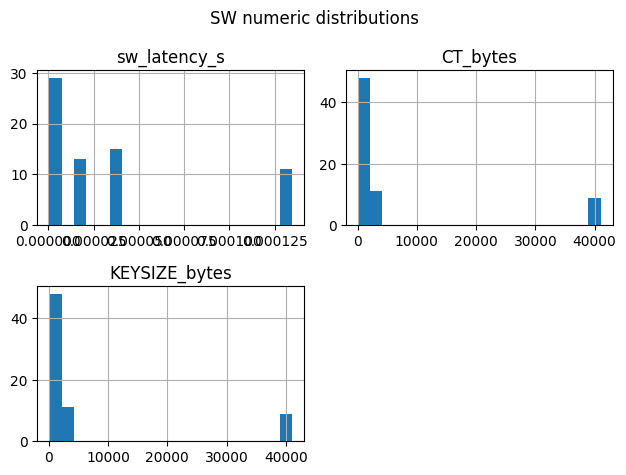

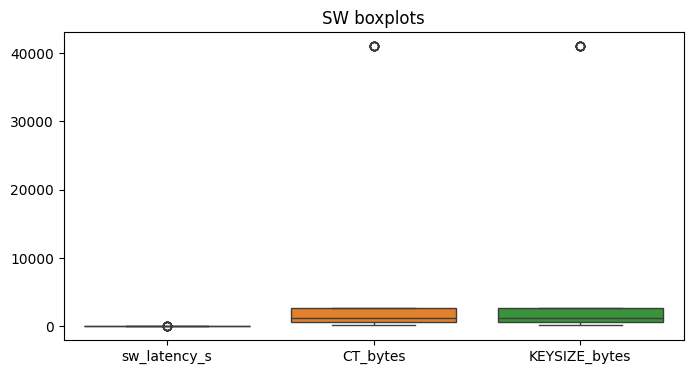

<Figure size 1000x500 with 0 Axes>

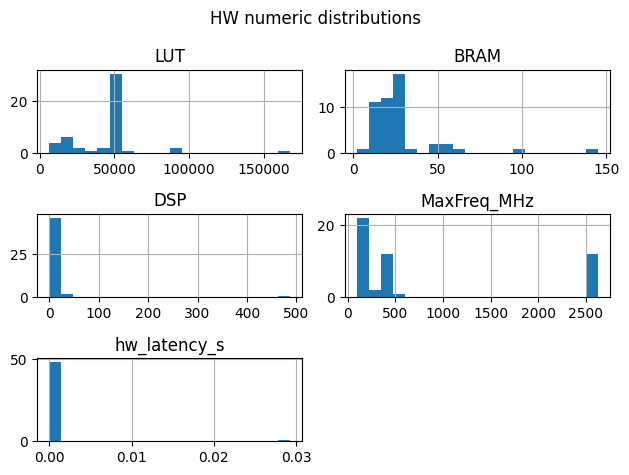

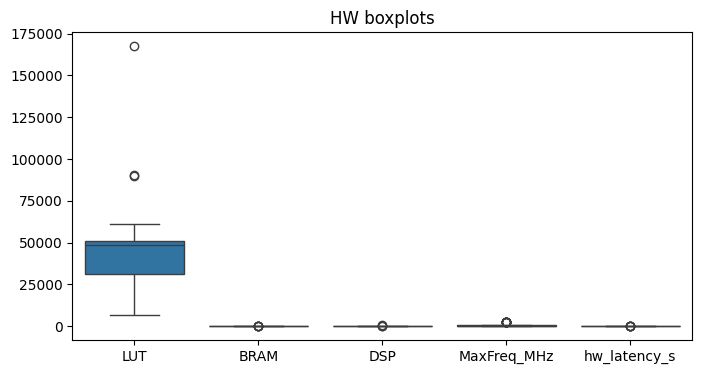

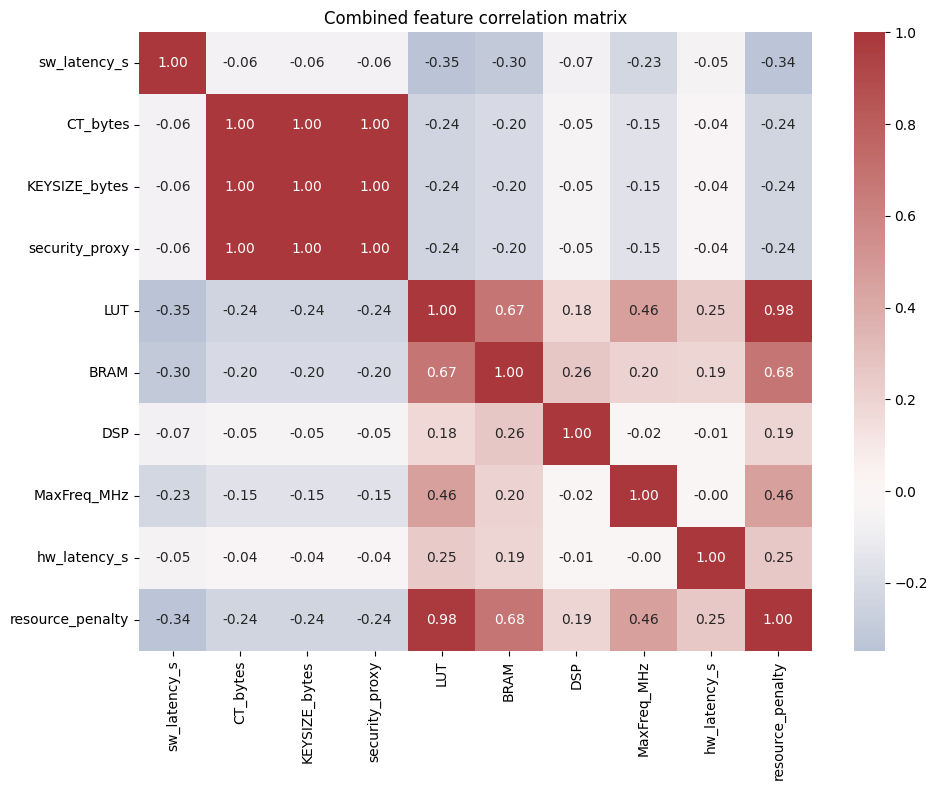

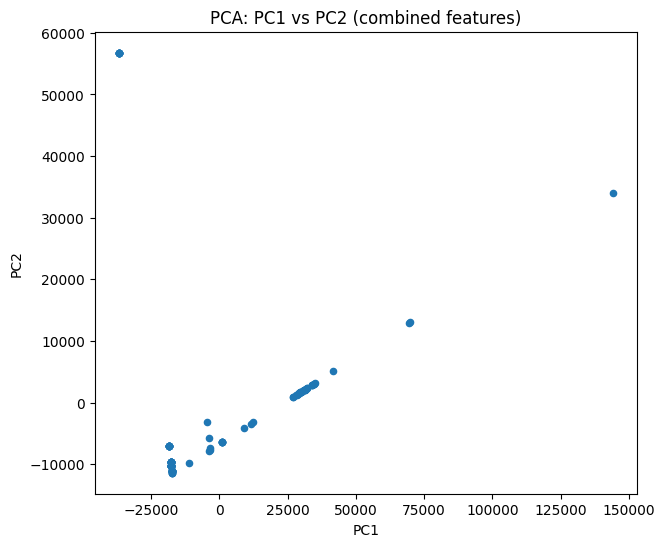

[i] EDA images saved to ./artifacts/ (and shown inline if DISPLAY_PLOTS=True)


In [8]:
# -------------------------
# SECTION 5: EDA - descriptive stats + plots + correlation + PCA
# -------------------------
print("\n[i] Doing EDA & saving plots...")

# descriptive stats
desc_sw = sw[["sw_latency_s","CT_bytes","KEYSIZE_bytes"]].describe().transpose()
desc_sw["skew"] = sw[["sw_latency_s","CT_bytes","KEYSIZE_bytes"]].skew()
desc_sw["kurtosis"] = sw[["sw_latency_s","CT_bytes","KEYSIZE_bytes"]].kurtosis()
desc_sw.to_csv(os.path.join(ART,"sw_descriptive_stats.csv"))

# histograms
fig = plt.figure(figsize=(10,5))
sw[["sw_latency_s","CT_bytes","KEYSIZE_bytes"]].hist(bins=20)
plt.suptitle("SW numeric distributions")
plt.tight_layout()
fig_path = os.path.join(ART,"sw_histograms.png")
plt.savefig(fig_path, dpi=180)
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# boxplots
fig = plt.figure(figsize=(8,4))
sns.boxplot(data=sw[["sw_latency_s","CT_bytes","KEYSIZE_bytes"]])
plt.title("SW boxplots")
fig_path = os.path.join(ART,"sw_boxplots.png")
plt.savefig(fig_path, dpi=180)
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# HW hist/box
fig = plt.figure(figsize=(10,5))
hw[["LUT","BRAM","DSP","MaxFreq_MHz","hw_latency_s"]].hist(bins=20)
plt.suptitle("HW numeric distributions")
plt.tight_layout()
plt.savefig(os.path.join(ART,"hw_histograms.png"), dpi=180)
if DISPLAY_PLOTS:
    plt.show()
plt.close()

fig = plt.figure(figsize=(8,4))
sns.boxplot(data=hw[["LUT","BRAM","DSP","MaxFreq_MHz","hw_latency_s"]])
plt.title("HW boxplots")
plt.savefig(os.path.join(ART,"hw_boxplots.png"), dpi=180)
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# correlation matrix
num_comb = combined.select_dtypes(include=[np.number])
corr = num_comb.corr()
fig = plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Combined feature correlation matrix")
plt.tight_layout()
plt.savefig(os.path.join(ART,"combined_correlation_matrix.png"), dpi=180)
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# PCA
pca_features = num_comb.fillna(0).values
pca = PCA(n_components=min(6, pca_features.shape[1]))
pca_trans = pca.fit_transform(pca_features)
explained = pca.explained_variance_ratio_
with open(os.path.join(ART,"pca_explained.json"), "w") as f:
    json.dump({"explained_variance_ratio": explained.tolist()}, f)
fig = plt.figure(figsize=(7,6))
plt.scatter(pca_trans[:,0], pca_trans[:,1], s=20)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA: PC1 vs PC2 (combined features)")
plt.savefig(os.path.join(ART,"pca_scatter.png"), dpi=180)
if DISPLAY_PLOTS:
    plt.show()
plt.close()

print("[i] EDA images saved to ./artifacts/ (and shown inline if DISPLAY_PLOTS=True)")


In [9]:
# -------------------------
# SECTION 6: Prepare ML datasets, encoding, scaling, feature selection
# -------------------------
print("\n[i] Preparing ML datasets & scalers...")
sw_feature_names = ["sw_latency_s","CT_bytes","KEYSIZE_bytes","security_proxy"]
X_sw = sw[sw_feature_names].astype(float).fillna(0)
le_sw = LabelEncoder()
y_sw = le_sw.fit_transform(sw["Algorithm_key"].astype(str))
joblib.dump(le_sw, os.path.join(ART,"le_sw.joblib"))


hw_feature_names = ["LUT","BRAM","DSP","MaxFreq_MHz","hw_latency_s","resource_penalty"]
X_hw = hw[hw_feature_names].astype(float).fillna(0)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ---- Data-driven HW clustering instead of manual rules ----
cluster_features = hw[["LUT","DSP","MaxFreq_MHz","hw_latency_s","resource_penalty"]].copy()

scaler_cluster = StandardScaler().fit(cluster_features)
cluster_scaled = scaler_cluster.transform(cluster_features)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_SEED, n_init=20)
cluster_labels = kmeans.fit_predict(cluster_scaled)

hw["hw_cluster"] = cluster_labels

# Map clusters to performance names based on LUT mean
import numpy as np

# Performance score: Higher freq = better, Lower latency = better, DSP = parallelism
def perf_score(df):
    return (df["MaxFreq_MHz"] / np.log1p(df["hw_latency_s"] + 1)) + (df["DSP"] * 2)

cluster_scores = hw.groupby("hw_cluster").apply(lambda df: perf_score(df).mean()).sort_values()

low_cluster  = cluster_scores.index[0]
mid_cluster  = cluster_scores.index[1]
high_cluster = cluster_scores.index[2]


def map_cluster_to_class(c):
    if c == high_cluster:
        return "high_perf"
    elif c == mid_cluster:
        return "mid_perf"
    else:
        return "low_perf"

hw["hw_class"] = hw["hw_cluster"].apply(map_cluster_to_class)
print("[i] HW classes distribution (data-driven clusters):")
print(hw["hw_class"].value_counts())

# def hw_classify_row(r):
#     # Updated thresholds for more balanced class distribution
#     if r["LUT"] > 25000 or r["DSP"] > 300 or r["MaxFreq_MHz"] > 250:
#         return "high_perf"
#     elif r["LUT"] > 9000 or r["DSP"] > 120 or r["MaxFreq_MHz"] > 140:
#         return "mid_perf"
#     else:
#         return "low_perf"

# hw["hw_class"] = hw.apply(hw_classify_row, axis=1)
le_hw = LabelEncoder()
y_hw = le_hw.fit_transform(hw["hw_class"])
joblib.dump(le_hw, os.path.join(ART,"le_hw.joblib"))

# feature selection for SW
skb = SelectKBest(score_func=mutual_info_classif, k=min(3, X_sw.shape[1]))
skb.fit(X_sw, y_sw)
selected_sw_cols = X_sw.columns[skb.get_support()].tolist()
print("[i] Selected SW features:", selected_sw_cols)
with open(os.path.join(ART,"selected_sw_features.json"), "w") as f:
    json.dump(selected_sw_cols, f)

# scalers
scaler_sw = StandardScaler().fit(X_sw)
X_sw_scaled = scaler_sw.transform(X_sw)
scaler_hw = StandardScaler().fit(X_hw)
X_hw_scaled = scaler_hw.transform(X_hw)
joblib.dump({"scaler": scaler_sw, "features": sw_feature_names}, os.path.join(ART,"scaler_sw.joblib"))
joblib.dump({"scaler": scaler_hw, "features": hw_feature_names}, os.path.join(ART,"scaler_hw.joblib"))



[i] Preparing ML datasets & scalers...
[i] HW classes distribution (data-driven clusters):
hw_class
mid_perf     34
high_perf    12
low_perf      3
Name: count, dtype: int64
[i] Selected SW features: ['CT_bytes', 'KEYSIZE_bytes', 'security_proxy']


['artifacts\\scaler_hw.joblib']

In [10]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

def safe_resample(X_train, y_train, name="dataset"):
    cnt = Counter(y_train)
    print(f"[i] {name} counts before resample:", cnt)

    # If any class has only 1 sample → SMOTE won't work → fallback to RandomOverSampler
    if min(cnt.values()) < 2:
        ros = RandomOverSampler(random_state=RANDOM_SEED)
        Xr, yr = ros.fit_resample(X_train, y_train)
        print(f"[i] {name}: RandomOverSampler used. New counts: {Counter(yr)}")
        return Xr, yr

    # SMOTE with safe neighbor count
    k_neighbors = min(5, min(cnt.values()) - 1)
    sm = SMOTE(random_state=RANDOM_SEED, k_neighbors=max(1, k_neighbors))
    Xr, yr = sm.fit_resample(X_train, y_train)
    print(f"[i] {name}: SMOTE applied (k={max(1,k_neighbors)}). New counts: {Counter(yr)}")
    return Xr, yr


In [11]:
print("\n[i] Train/test split and safe resampling...")

from collections import Counter

# Check if stratification is possible for SW
sw_counts = Counter(y_sw)
if min(sw_counts.values()) < 2:
    print("[!] SW: Some classes have fewer than 2 samples → disabling stratify.")
    strat_sw = None
else:
    strat_sw = y_sw

# Check if stratification is possible for HW
hw_counts = Counter(y_hw)
if min(hw_counts.values()) < 2:
    print("[!] HW: Some classes have fewer than 2 samples → disabling stratify.")
    strat_hw = None
else:
    strat_hw = y_hw

# Train/test split using safe stratification
Xsw_train, Xsw_test, ysw_train, ysw_test = train_test_split(
    X_sw_scaled, y_sw, test_size=0.2, random_state=RANDOM_SEED, stratify=strat_sw)

Xhw_train, Xhw_test, yhw_train, yhw_test = train_test_split(
    X_hw_scaled, y_hw, test_size=0.2, random_state=RANDOM_SEED, stratify=strat_hw)

print("[i] SW counts before:", Counter(ysw_train))
print("[i] HW counts before:", Counter(yhw_train))

# APPLY BALANCING
Xsw_train, ysw_train = safe_resample(Xsw_train, ysw_train, name="SW")
Xhw_train, yhw_train = safe_resample(Xhw_train, yhw_train, name="HW")

print("[i] SW counts after:", Counter(ysw_train))
print("[i] HW counts after:", Counter(yhw_train))



[i] Train/test split and safe resampling...
[!] SW: Some classes have fewer than 2 samples → disabling stratify.
[i] SW counts before: Counter({4: 13, 5: 12, 3: 10, 1: 9, 6: 7, 2: 2, 0: 1})
[i] HW counts before: Counter({2: 27, 0: 10, 1: 2})
[i] SW counts before resample: Counter({4: 13, 5: 12, 3: 10, 1: 9, 6: 7, 2: 2, 0: 1})
[i] SW: RandomOverSampler used. New counts: Counter({5: 13, 3: 13, 4: 13, 6: 13, 1: 13, 0: 13, 2: 13})
[i] HW counts before resample: Counter({2: 27, 0: 10, 1: 2})
[i] HW: SMOTE applied (k=1). New counts: Counter({2: 27, 0: 27, 1: 27})
[i] SW counts after: Counter({5: 13, 3: 13, 4: 13, 6: 13, 1: 13, 0: 13, 2: 13})
[i] HW counts after: Counter({2: 27, 0: 27, 1: 27})


In [12]:
# ============================
# Ensure model availability flags exist
# ============================

# HAS_XGB = False
# HAS_LGB = False

# Try importing XGBoost
try:
    import xgboost as xgb
    HAS_XGB = False
    print("[OK] XGBoost detected ✅")
except Exception as e:
    print("[!] XGBoost not available:", e)

# Try importing LightGBM
try:
    import lightgbm as lgb
    HAS_LGB = False
    print("[OK] LightGBM detected ✅")
except Exception as e:
    print("[!] LightGBM not available:", e)


[OK] XGBoost detected ✅
[OK] LightGBM detected ✅


In [13]:
# -------------------------
# SECTION 8: Train supervised models (SW + HW)
# -------------------------
print("\n[i] Training supervised models...")

# SW baseline RF
rf_sw = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, class_weight='balanced')
rf_sw.fit(Xsw_train, ysw_train)
print("[i] RF SW acc:", accuracy_score(ysw_test, rf_sw.predict(Xsw_test)))
print(classification_report(ysw_test, rf_sw.predict(Xsw_test)))

best_sw_model = rf_sw
if HAS_XGB:
    try:
        xgb_sw = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_SEED)
        xgb_sw.fit(Xsw_train, ysw_train, eval_set=[(Xsw_test, ysw_test)], early_stopping_rounds=20, verbose=False)
        print("[i] XGBoost SW acc:", accuracy_score(ysw_test, xgb_sw.predict(Xsw_test)))
        best_sw_model = xgb_sw
    except Exception as e:
        print("[!] XGBoost SW training failed:", e)
if HAS_LGB:
    try:
        lgb_sw = lgb.LGBMClassifier(n_estimators=200, random_state=RANDOM_SEED)
        lgb_sw.fit(Xsw_train, ysw_train, eval_set=[(Xsw_test, ysw_test)], early_stopping_rounds=20, verbose=False)
        print("[i] LightGBM SW acc:", accuracy_score(ysw_test, lgb_sw.predict(Xsw_test)))
        best_sw_model = lgb_sw
    except Exception as e:
        print("[!] LightGBM SW training failed:", e)

joblib.dump({"model": best_sw_model, "features": sw_feature_names}, os.path.join(ART,"sw_model_package.joblib"))
print("[i] Best SW model saved.")

# HW classifier
rf_hw = RandomForestClassifier(n_estimators=150, random_state=RANDOM_SEED, class_weight='balanced')
rf_hw.fit(Xhw_train, yhw_train)
print("[i] RF HW acc:", accuracy_score(yhw_test, rf_hw.predict(Xhw_test)))
print(classification_report(yhw_test, rf_hw.predict(Xhw_test)))
best_hw_model = rf_hw
if HAS_LGB:
    try:
        lgb_hw = lgb.LGBMClassifier(n_estimators=200, random_state=RANDOM_SEED)
        lgb_hw.fit(Xhw_train, yhw_train, eval_set=[(Xhw_test, yhw_test)], early_stopping_rounds=20, verbose=False)
        print("[i] LightGBM HW acc:", accuracy_score(yhw_test, lgb_hw.predict(Xhw_test)))
        best_hw_model = lgb_hw
    except Exception as e:
        print("[!] LightGBM HW training failed:", e)
if HAS_XGB:
    try:
        xgb_hw = xgb.XGBClassifier(n_estimators=200, random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='mlogloss')
        xgb_hw.fit(Xhw_train, yhw_train, eval_set=[(Xhw_test, yhw_test)], early_stopping_rounds=20, verbose=False)
        print("[i] XGBoost HW acc:", accuracy_score(yhw_test, xgb_hw.predict(Xhw_test)))
        best_hw_model = xgb_hw
    except Exception as e:
        print("[!] XGBoost HW training failed:", e)

joblib.dump({"model": best_hw_model, "features": hw_feature_names}, os.path.join(ART,"hw_model_package.joblib"))
print("[i] Best HW model saved.")

# save scalers & encoders
joblib.dump({"scaler": scaler_sw, "features": sw_feature_names}, os.path.join(ART,"scaler_sw.joblib"))
joblib.dump({"scaler": scaler_hw, "features": hw_feature_names}, os.path.join(ART,"scaler_hw.joblib"))
joblib.dump(le_sw, os.path.join(ART,"le_sw.joblib"))
joblib.dump(le_hw, os.path.join(ART,"le_hw.joblib"))



[i] Training supervised models...
[i] RF SW acc: 0.35714285714285715
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.50      0.50         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.50      0.50      0.50         2
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         2

    accuracy                           0.36        14
   macro avg       0.29      0.29      0.29        14
weighted avg       0.36      0.36      0.36        14

[i] Best SW model saved.
[i] RF HW acc: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7

    accuracy                           1.00        10
   macro avg     

['artifacts\\le_hw.joblib']

In [14]:
#################check 
import os, time, joblib
pkg_path = os.path.join(ART, "hw_model_package.joblib")
enc_path = os.path.join(ART, "le_hw.joblib")
print("[dbg] hw_model mtime:", time.ctime(os.path.getmtime(pkg_path)))
print("[dbg] le_hw    mtime:", time.ctime(os.path.getmtime(enc_path)))
########################## check

[dbg] hw_model mtime: Thu Nov  6 15:20:34 2025
[dbg] le_hw    mtime: Thu Nov  6 15:20:34 2025


In [15]:
# -------------------------
# SECTION 9: Optional anomaly detection (autoencoder + OneClassSVM)
# -------------------------
if HAS_TF:
    try:
        X_hw_all = scaler_hw.transform(X_hw)
        dim = X_hw_all.shape[1]
        enc = max(2, dim//2)
        inp = layers.Input(shape=(dim,))
        x = layers.Dense(enc*2, activation='relu')(inp)
        x = layers.Dense(enc, activation='relu')(x)
        z = layers.Dense(max(1,enc//2), activation='relu')(x)
        x = layers.Dense(enc, activation='relu')(z)
        x = layers.Dense(enc*2, activation='relu')(x)
        out = layers.Dense(dim, activation='linear')(x)
        ae = models.Model(inp,out)
        ae.compile(optimizer='adam', loss='mse')
        ae.fit(X_hw_all, X_hw_all, epochs=40, batch_size=16, validation_split=0.1, verbose=0,
               callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)])
        reconst = np.mean(np.square(ae.predict(X_hw_all) - X_hw_all), axis=1)
        ae_thresh = float(reconst.mean() + 3*reconst.std())
        joblib.dump({"ae": ae, "thresh": ae_thresh, "features": hw_feature_names}, os.path.join(ART,"hw_autoencoder.joblib"))
        print("[i] Autoencoder trained and saved.")
    except Exception as e:
        print("[!] Autoencoder training failed:", e)

try:
    X_hw_all = scaler_hw.transform(X_hw)
    oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
    oc_svm.fit(X_hw_all)
    joblib.dump({"oc_svm": oc_svm, "scaler": scaler_hw, "features": hw_feature_names}, os.path.join(ART,"hw_ocsvm.joblib"))
    print("[i] OneClassSVM saved.")
except Exception as e:
    print("[!] OneClassSVM training failed:", e)


[i] OneClassSVM saved.


In [16]:
# -------------------------
# SECTION 10: Inference helper (model-guided, generated HW values)
# -------------------------
print("\n[i] Setting up inference helper...")

# load artifacts if present (safe)
sw_pkg = joblib.load(os.path.join(ART,"sw_model_package.joblib")) if os.path.exists(os.path.join(ART,"sw_model_package.joblib")) else {"model": best_sw_model, "features": sw_feature_names}
hw_pkg = joblib.load(os.path.join(ART,"hw_model_package.joblib")) if os.path.exists(os.path.join(ART,"hw_model_package.joblib")) else {"model": best_hw_model, "features": hw_feature_names}
scaler_sw_pkg = joblib.load(os.path.join(ART,"scaler_sw.joblib")) if os.path.exists(os.path.join(ART,"scaler_sw.joblib")) else {"scaler": scaler_sw, "features": sw_feature_names}
scaler_hw_pkg = joblib.load(os.path.join(ART,"scaler_hw.joblib")) if os.path.exists(os.path.join(ART,"scaler_hw.joblib")) else {"scaler": scaler_hw, "features": hw_feature_names}
le_sw_pkg = joblib.load(os.path.join(ART,"le_sw.joblib")) if os.path.exists(os.path.join(ART,"le_sw.joblib")) else le_sw
le_hw_pkg = joblib.load(os.path.join(ART,"le_hw.joblib")) if os.path.exists(os.path.join(ART,"le_hw.joblib")) else le_hw


###################check
print("[dbg] Inference using model file mtime:", time.ctime(os.path.getmtime(os.path.join(ART,"hw_model_package.joblib"))))
print("[dbg] Inference using encoder file mtime:", time.ctime(os.path.getmtime(os.path.join(ART,"le_hw.joblib"))))
print("[dbg] le_hw classes:", getattr(le_hw, "classes_", None))
############################################

model_sw = sw_pkg["model"]
model_hw = hw_pkg["model"]
scaler_sw = scaler_sw_pkg["scaler"]
scaler_hw = scaler_hw_pkg["scaler"]
sw_feature_names = scaler_sw_pkg["features"]
hw_feature_names = scaler_hw_pkg["features"]
le_sw = le_sw_pkg
le_hw = le_hw_pkg

# helper to generate plausible hw numeric vector for a predicted class:
# take mean+std of that class from HW table and perturb by gaussian noise
class_stats_by_hwclass = {}
for cls in hw["hw_class"].unique():
    rows = hw[hw["hw_class"]==cls][hw_feature_names]
    if len(rows)>0:
        class_stats_by_hwclass[cls] = {
            "mean": rows.mean().to_dict(),
            "std": rows.std(ddof=0).replace(0, max(1e-6, rows.mean().abs().replace(0,1).mean())).to_dict()
        }
    else:
        class_stats_by_hwclass[cls] = None

def generate_hw_values_for_class(hw_class, randomness=0.15): #0.15
    """Return a dict of hw_feature_names -> value for a hw_class by sampling mean +/- noise."""
    stats = class_stats_by_hwclass.get(hw_class)
    if not stats or stats["mean"] is None:
        # fallback: global medians
        med = X_hw.mean(axis=0)
        return dict(zip(hw_feature_names, med.tolist()))
    vals = {}
    for f in hw_feature_names:
        mu = float(stats["mean"].get(f, 0.0))
        sigma = float(stats["std"].get(f, 0.0))
        # define noise scale: use sigma or a fraction of mean
        noise = np.random.normal(0, max(sigma, abs(mu)*randomness))
        val = max(0.0, mu + noise)
        vals[f] = val
    return vals

# inference function
def infer_from_testcase_row(tc_row, gen_hw_probability=0.8):
    """
    tc_row: dict or pd.Series
    gen_hw_probability: probability to generate model-guided HW values (not strictly lookup). 0..1
    returns: dict with chosen sw algorithm, sw row, predicted hw class, chosen hw values (dict), anomaly info
    """
    # Build SW sample: try to lookup by sender algo, else use medians
    sender_algo_raw = str(tc_row.get("Sender Algo","")).lower().strip()
    sender_key = re.sub(r'[^a-z0-9]','', sender_algo_raw)
    sw_match = combined[combined["Algorithm_key"]==sender_key]
    if not sw_match.empty:
        sw_sample = sw_match.iloc[0]
        sw_feat = [sw_sample["sw_latency_s"], sw_sample["CT_bytes"], sw_sample["KEYSIZE_bytes"], sw_sample["security_proxy"]]
    else:
        sw_feat = [float(sw["sw_latency_s"].median()), float(sw["CT_bytes"].median()), float(sw["KEYSIZE_bytes"].median()), float(sw["security_proxy"].median())]

    # scale SW features (safe)
    try:
        Xs = scaler_sw.transform([sw_feat])
    except Exception:
        # align dims
        expected = len(sw_feature_names)
        arr = list(sw_feat)[:expected] + [0.0]*max(0, expected - len(sw_feat))
        Xs = np.array([arr])

    # Predict SW algorithm via classifier (model uses encoded labels)
    chosen_sw_row = {}
    alg_display = None
    if model_sw is not None:
        try:
            pred_idx = int(model_sw.predict(Xs)[0])
            alg_key_pred = le_sw.inverse_transform([pred_idx])[0] if le_sw is not None else pred_idx
            rep = sw[sw["Algorithm_key"]==alg_key_pred]
            if not rep.empty:
                chosen_sw_row = rep.sample(1, random_state=RANDOM_SEED).iloc[0].to_dict()
                alg_display = chosen_sw_row.get("Algorithm", alg_key_pred)
            else:
                alg_display = alg_key_pred
                chosen_sw_row = {"Algorithm_key": alg_key_pred}
        except Exception:
            alg_display = sw_sample["Algorithm"] if not sw_match.empty else sw["Algorithm"].iloc[0]
            chosen_sw_row = sw_sample.to_dict() if not sw_match.empty else sw.iloc[0].to_dict()
    else:
        alg_display = sw_sample["Algorithm"] if not sw_match.empty else sw["Algorithm"].iloc[0]
        chosen_sw_row = sw_sample.to_dict() if not sw_match.empty else sw.iloc[0].to_dict()

    # Build HW feature vector heuristically
    hw_base = str(tc_row.get("HW_Base","")).lower()
    budget = str(tc_row.get("Budget","")).lower()
    if ("high-performance" in hw_base) or ("high" in budget):
        quantile = 0.90
    elif ("mid-tier" in hw_base) or ("medium" in budget):
        quantile = 0.50
    else:
        quantile = 0.10

    lut_v = float(hw["LUT"].quantile(quantile))
    bram_v = float(hw["BRAM"].quantile(quantile))
    dsp_v = float(hw["DSP"].quantile(quantile))
    freq_v = float(hw["MaxFreq_MHz"].quantile(quantile))
    # latency: for high perf we want small latency (low quantile), for low perf high latency
    latency_v = float(hw["hw_latency_s"].quantile(0.10)) if quantile>0.5 else float(hw["hw_latency_s"].quantile(0.90))
    resource_penalty_v = float(hw["resource_penalty"].quantile(quantile))
    hw_feat_vals = [lut_v, bram_v, dsp_v, freq_v, latency_v, resource_penalty_v]

    # scale HW features for classifier
    try:
        Xh = scaler_hw.transform([hw_feat_vals])
    except Exception:
        expected = len(hw_feature_names)
        arr = hw_feat_vals[:expected] + [0.0]*max(0, expected - len(hw_feat_vals))
        Xh = np.array([arr])

    # Predict HW class
    predicted_hw_class = None
    rep_hw_row = {}
    if model_hw is not None:
        try:
            pred_hw_idx = int(model_hw.predict(Xh)[0])
            hw_class_pred = le_hw.inverse_transform([pred_hw_idx])[0] if le_hw is not None else pred_hw_idx
            predicted_hw_class = hw_class_pred
            # Decide whether to pick a real row or generate plausible values
            if np.random.rand() < gen_hw_probability:
                # Generate plausible hw numeric vector from class stats (model-guided)
                gen_vals = generate_hw_values_for_class(hw_class_pred, randomness=0.12)
                rep_hw_row = {"hw_class": hw_class_pred}
                rep_hw_row.update(gen_vals)
                # optionally include a closest real row id
                nearest = hw[hw["hw_class"]==hw_class_pred]
                if len(nearest)>0:
                    rep_hw_row["guide_example"] = nearest.sample(1, random_state=RANDOM_SEED)["Algorithm"].iloc[0]
            else:
                # pick real representative row from dataset
                rep = hw[hw["hw_class"]==hw_class_pred].sort_values("MaxFreq_MHz", ascending=False)
                rep_hw_row = rep.iloc[0].to_dict() if not rep.empty else generate_hw_values_for_class(hw_class_pred, randomness=0.12)
        except Exception:
            # fallback heuristic
            predicted_hw_class = None
            rep_hw_row = dict(zip(hw_feature_names, hw_feat_vals))
    else:
        # no model: return heuristic values but include class guess
        # use simple heuristic classifier:
        predicted_hw_class = hw_classify_row(dict(zip(hw_feature_names, hw_feat_vals)))
        rep_hw_row = dict(zip(hw_feature_names, hw_feat_vals))

    # anomaly detection with autoencoder if available
    ae_info = {}
    ae_pkg_path = os.path.join(ART, "hw_autoencoder.joblib")
    try:
        if os.path.exists(ae_pkg_path):
            ae_pkg = joblib.load(ae_pkg_path)
            ae_model = ae_pkg.get("ae")
            thresh = ae_pkg.get("thresh")
            scaled = scaler_hw.transform([list(rep_hw_row.get(f,0.0) for f in hw_feature_names)])
            recon = ae_model.predict(scaled)
            re_err = float(np.mean((recon - scaled)**2))
            ae_info = {"recon_error": re_err, "thresh": thresh, "anomaly": re_err>thresh}
    except Exception:
        ae_info = {}

    return {
        "testcase_row": dict(tc_row),
        "chosen_sw_algorithm": alg_display,
        "chosen_sw_row": chosen_sw_row,
        "predicted_hw_class": predicted_hw_class,
        "chosen_hw_row": rep_hw_row,
        "hw_anomaly_info": ae_info,
        "sw_features_used": dict(zip(sw_feature_names, sw_feat)),
        "hw_features_used": dict(zip(hw_feature_names, hw_feat_vals))
    }



[i] Setting up inference helper...
[dbg] Inference using model file mtime: Thu Nov  6 15:20:34 2025
[dbg] Inference using encoder file mtime: Thu Nov  6 15:20:34 2025
[dbg] le_hw classes: ['high_perf' 'low_perf' 'mid_perf']


In [17]:
# -------------------------
# SECTION 11: Demo inference printing & saving
# -------------------------
print("\n[i] Running inference on first 12 testcases and printing readable outputs...")
demo_results = []
for idx, row in testcases.tail(30).iterrows():
    out = infer_from_testcase_row(row)
    demo_results.append(out)
    pretty_print_inference(idx, out)

# save demo JSON
pd.DataFrame(demo_results).to_json(os.path.join(ART,"demo_inference_results.json"), orient="records", indent=2)
print(f"[i] Demo inference results saved -> {os.path.join(ART,'demo_inference_results.json')}")

print("\n[i] Pipeline finished. Artifacts (plots/models/results) are in ./artifacts/")



[i] Running inference on first 12 testcases and printing readable outputs...

Case 66: SBI -> Saraswat
----------------------------------------------------------------------
Enterprise  : big
Infra       : old
Budget      : High
Legacy      : Present
Deployment  : Different servers
Sender Algo : Classical-RSA/AES
Receiver Algo: Classical-RSA/AES (downgraded)
HW_Base     : Commodity CPU / Software-optimized node
----------------------------------------------------------------------
Chosen SW algorithm: Kyber768
SW representative (from dataset):
{   'Algorithm': 'Kyber768',
    'CT_bytes': 1150,
    'KEYSIZE_bytes': 1150,
    'sw_latency_s': 3.75e-05}
----------------------------------------------------------------------
Predicted HW class: high_perf
HW representative (generated / model-guided):
  hw_class       : high_perf
  LUT            : 60702.0828
  BRAM           : 22.3041
  DSP            : 0.7839
  MaxFreq_MHz    : 3908.816
  hw_latency_s   : 0.0003
  resource_penalty: 5.3472
 

In [18]:
# -------------------------
# SECTION 11: Demo inference printing & saving
# -------------------------
print("\n[i] Running inference on last 30 testcases and printing readable outputs...")
demo_results = []
hw_classes_predicted = []

for idx, row in testcases.tail(96).iterrows():
    out = infer_from_testcase_row(row)
    demo_results.append(out)
    hw_classes_predicted.append(out.get("predicted_hw_class"))
    pretty_print_inference(idx, out)

# ---- NEW: Print class distribution summary ----
from collections import Counter
print("\n================ HW CLASS DISTRIBUTION (INFERENCE) ================")
for cls, count in Counter(hw_classes_predicted).items():
    print(f"{cls:10} → {count}")
print("==================================================================\n")

# save demo JSON
pd.DataFrame(demo_results).to_json(os.path.join(ART,"demo_inference_results.json"), orient="records", indent=2)
print(f"[i] Demo inference results saved -> {os.path.join(ART,'demo_inference_results.json')}")

print("\n[i] Pipeline finished. Artifacts (plots/models/results) are in ./artifacts/")



[i] Running inference on last 30 testcases and printing readable outputs...

Case 0: ICICI -> ICICI
----------------------------------------------------------------------
Enterprise  : big
Infra       : new
Budget      : High
Legacy      : Present
Deployment  : Same server
Sender Algo : PQC-Kyber/Falcon
Receiver Algo: PQC-Kyber/Falcon
HW_Base     : Mid-tier FPGA + CPU combo
----------------------------------------------------------------------
Chosen SW algorithm: Kyber768
SW representative (from dataset):
{   'Algorithm': 'Kyber768',
    'CT_bytes': 1150,
    'KEYSIZE_bytes': 1150,
    'sw_latency_s': 3.75e-05}
----------------------------------------------------------------------
Predicted HW class: high_perf
HW representative (generated / model-guided):
  Design         : [13]
  Algorithm      : SPHINCS+-128s-simple
  pk+sig (KB)    : 7.9
  Max Freq (MHz) : 250 & 500^3
  LUT            : 48231.0
  FF             : 72514
  DSP            : 0.0
  BRAM           : 11.5
  Keygen cycles

In [19]:
hw_summary = hw[["Algorithm","LUT","DSP","MaxFreq_MHz","hw_class"]]
print(hw_summary.head(30))
print(hw_summary["hw_class"].value_counts())


               Algorithm            LUT         DSP  MaxFreq_MHz   hw_class
0   SPHINCS+-128s-simple   48231.000000    0.000000        375.0   mid_perf
1   SPHINCS+-128s-robust   49146.000000    0.000000        375.0   mid_perf
2   SPHINCS+-128f-simple   47991.000000    1.000000        375.0   mid_perf
3   SPHINCS+-128f-robust   48930.000000    1.000000        375.0   mid_perf
4   SPHINCS+-192s-simple   48725.000000    0.000000        375.0   mid_perf
5   SPHINCS+-192s-robust   50064.000000    0.000000        375.0   mid_perf
6   SPHINCS+-192f-simple   48398.000000    1.000000        375.0   mid_perf
7   SPHINCS+-192f-robust   47227.000000    1.000000        375.0   mid_perf
8   SPHINCS+-256s-simple   51130.000000    0.000000        375.0   mid_perf
9   SPHINCS+-256s-robust   50070.000000    1.000000        375.0   mid_perf
10  SPHINCS+-256f-simple   51009.000000    1.000000        375.0   mid_perf
11  SPHINCS+-256f-robust   50341.000000    1.000000        375.0   mid_perf
12          

In [20]:
from sklearn.metrics import accuracy_score
import joblib, os
print("\n==================== MODEL ACCURACY SUMMARY ====================\n")

# --- Evaluate available SW models ---
print("[SW MODEL ACCURACY]")
try:
    print(f"  RandomForest (SW): {accuracy_score(ysw_test, rf_sw.predict(Xsw_test)):.4f}")
except:
    pass
try:
    if 'xgb_sw' in globals():
        print(f"  XGBoost (SW)     : {accuracy_score(ysw_test, xgb_sw.predict(Xsw_test)):.4f}")
except:
    pass
try:
    if 'lgb_sw' in globals():
        print(f"  LightGBM (SW)    : {accuracy_score(ysw_test, lgb_sw.predict(Xsw_test)):.4f}")
except:
    pass
print()

# --- Evaluate available HW models ---
print("[HW MODEL ACCURACY]")
try:
    print(f"  RandomForest (HW): {accuracy_score(yhw_test, rf_hw.predict(Xhw_test)):.4f}")
except:
    pass
try:
    if 'xgb_hw' in globals():
        print(f"  XGBoost (HW)     : {accuracy_score(yhw_test, xgb_hw.predict(Xhw_test)):.4f}")
except:
    pass
try:
    if 'lgb_hw' in globals():
        print(f"  LightGBM (HW)    : {accuracy_score(yhw_test, lgb_hw.predict(Xhw_test)):.4f}")
except:
    pass
print()

# --- One-Class SVM anomaly detection -----
ocsvm_path = os.path.join(ART, "hw_ocsvm.joblib")
if os.path.exists(ocsvm_path):
    oc_pkg = joblib.load(ocsvm_path)
    oc_svm = oc_pkg["oc_svm"]
    scaled_hw = oc_pkg["scaler"].transform(X_hw)
    preds = oc_svm.predict(scaled_hw)
    anomaly_rate = (preds == -1).mean()
    print("[ONE-CLASS SVM ANOMALY RATE]")
    print(f"  Anomaly Rate → {anomaly_rate*100:.2f}% flagged anomalies\n")

print("================================================================\n")



==================== MODEL ACCURACY SUMMARY ====================

[SW MODEL ACCURACY]
  RandomForest (SW): 0.3571

[HW MODEL ACCURACY]
  RandomForest (HW): 1.0000

[ONE-CLASS SVM ANOMALY RATE]
  Anomaly Rate → 10.20% flagged anomalies




In [21]:
print("===== DEBUG: CHECK XGBoost & LightGBM IMPORT =====")

# Check Python path
import sys
print("Python:", sys.executable)

# Try import XGBoost manually
try:
    import xgboost as xgb
    print("XGBoost ✅ Working:", xgb.__version__)
    HAS_XGB = True
except Exception as e:
    print("XGBoost ❌ FAILED:", e)
    HAS_XGB = False

# Try import LightGBM manually
try:
    import lightgbm as lgb
    print("LightGBM ✅ Working:", lgb.__version__)
    HAS_LGB = True
except Exception as e:
    print("LightGBM ❌ FAILED:", e)
    HAS_LGB = False

print("HAS_XGB =", HAS_XGB)
print("HAS_LGB =", HAS_LGB)


===== DEBUG: CHECK XGBoost & LightGBM IMPORT =====
Python: e:\cuda\Scripts\python.exe
XGBoost ✅ Working: 2.1.1
LightGBM ✅ Working: 4.5.0
HAS_XGB = True
HAS_LGB = True


In [2]:
import joblib
import numpy as np
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

ART = r"C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\artifacts"   # <-- change this to your PC path

# Load packages
sw_pkg = joblib.load(ART + r"\sw_model_package.joblib")
hw_pkg = joblib.load(ART + r"\hw_model_package.joblib")

model_sw = sw_pkg["model"]
model_hw = hw_pkg["model"]

# Define input shapes (same feature count used during training)
sw_input_dim = 4   # sw_latency, ct_bytes, keysize, security
hw_input_dim = 6   # lut, bram, dsp, freq, lat, penalty

# Convert Software Model
sw_initial_type = [('input', FloatTensorType([None, sw_input_dim]))]
sw_onnx = convert_sklearn(model_sw, initial_types=sw_initial_type)
with open(ART + "sw_model.onnx", "wb") as f:
    f.write(sw_onnx.SerializeToString())

# Convert Hardware Model
hw_initial_type = [('input', FloatTensorType([None, hw_input_dim]))]
hw_onnx = convert_sklearn(model_hw, initial_types=hw_initial_type)
with open(ART + "hw_model.onnx", "wb") as f:
    f.write(hw_onnx.SerializeToString())

print("✅ ONNX Conversion Complete!")


✅ ONNX Conversion Complete!


In [3]:
import joblib
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

ART = r"C:\Users\Prathamesh Shetty\Desktop\Code_Implementation\artifacts"   # <-- change to your folder

# Load trained models
sw_pkg = joblib.load(ART + r"\sw_model_package.joblib")
hw_pkg = joblib.load(ART + r"\hw_model_package.joblib")

model_sw = sw_pkg["model"]
model_hw = hw_pkg["model"]

# Input dimensionality
sw_input_dim = 4
hw_input_dim = 6

# Convert Software Model with IR ≤ 9
sw_onnx = convert_sklearn(
    model_sw,
    initial_types=[('input', FloatTensorType([None, sw_input_dim]))],
    target_opset=12  # ensures IR <= 9 compatibility
)

with open(ART + "sw_model.onnx", "wb") as f:
    f.write(sw_onnx.SerializeToString())

# Convert Hardware Model with IR ≤ 9
hw_onnx = convert_sklearn(
    model_hw,
    initial_types=[('input', FloatTensorType([None, hw_input_dim]))],
    target_opset=12
)

with open(ART + "hw_model.onnx", "wb") as f:
    f.write(hw_onnx.SerializeToString())

print("✅ ONNX models exported with opset=12 (IR ≤ 9). Ready for Raspberry Pi.")


✅ ONNX models exported with opset=12 (IR ≤ 9). Ready for Raspberry Pi.
